In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (15,10)
mpl.rcParams['font.size'] = 16  # Set the font size for all elements


from copy import deepcopy


#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Having to import from subfolders of parent directories is a nightmare
import sys
import os
current = os.path.dirname(os.path.realpath("Single-House-Optimization.py"))
parent = os.path.dirname(current)
sys.path.append(parent+"\Functions")

#From Functions folder
from LoadSeries import load_series, moving_average
from Merge import merge
from Battery import Battery
from DPModel import DP, DP_carb
from Logic import logic_bat
from Funcs_Logic_DP import action_rollout, pred_logic_rollout, print_price_summary, logic_series_print
from MPC import MPC, MPC_carb, MPC_price_carb, MPCModel
from Predictions import RF_Predictions
from SARIMAfx import SARIMA

In [17]:
class single_house_opt(SARIMA):
    
    def __init__(self, house, start_date='2022-06-19 00:00:00', end_date='2022-06-25 23:00:00', bat_capacity=13, max_charge=7, stepsize=2):
        self.house = house
        self.start_date = start_date
        self.end_date = end_date
        self.bat_capacity = bat_capacity
        self.max_charge = max_charge
        self.stepsize = stepsize

        self.merged = merge(str(self.house))
        self.sarima_model = SARIMA(self.house)
        self.mpc_model = MPCModel(self.house, 0.1, 0.0, 1, self.max_charge, self.bat_capacity)
    
        self.N = len(pd.date_range(start=self.start_date,end=self.end_date,freq="h"))
        remainder = self.N%24

        if remainder==0:
            print(f"Period is of size {self.N} hours = {self.N//24} days\nPeriod from {self.start_date} to {self.end_date} for house {self.house}")
        elif remainder==1:
            print(f"Period of size {self.N} hours = {self.N//24} days and {remainder} hour\nPeriod from {self.start_date} to {self.end_date}")
        else:
            print(f"Period of size {self.N} hours = {self.N//24} days and {remainder} hours\nPeriod from {self.start_date} to {self.end_date}")
        print('--- \n')
        
    def opt_results(self,forecaster,ratio=0.5):
        series_no_battery, series_battery, series_battery_DP_price, series_battery_DP_carb, series_battery_MPC_price, series_battery_MPC_carb, series_battery_MPC_both = (pd.DataFrame(columns=self.merged.columns),)*7
        battery_no   = Battery(max_capacity=0,max_charge=0)
        battery, DPbat_price, DPbat_carb, MPCbat_price, MPCbat_carb, MPCbat_both = (Battery(max_capacity=self.bat_capacity, max_charge=self.max_charge),) * 6

        num_loops = int(np.ceil(self.N/self.stepsize))
        remainder = self.N%self.stepsize
        length = self.stepsize
        
        Start_i = self.start_date
        preds = pd.DataFrame() 
        
        for i in range(num_loops):
            if i == num_loops-1:
                length = length if remainder == 0 else remainder
                
            End_i = pd.date_range(start=Start_i, periods=24, freq="h")[-1]

            merged_i = self.merged.loc[Start_i:End_i]
            print(f"Loop number {i+1} of {num_loops}")
            print(f"Predicting period from {Start_i} to {End_i} (n = {len(pd.date_range(Start_i, End_i, freq='H'))})")          
            
            if forecaster=='sarima':
                pred_i = self.sarima_model.SARIMA(Start_i, End_i)
            else:
                print('RF under construction')    
            
            print(f"Taking actions the first {length} actions from {Start_i} to {pred_i.index[length-1]}")
            temp_no_bat = pred_logic_rollout(merged_i, pred_i, deepcopy(battery_no), logic_bat)
            temp_bat = pred_logic_rollout(merged_i, pred_i, deepcopy(battery), logic_bat)
            
            print("\r                                             ",end="")
            print("\rRunning DP price optimization",end="")
            actions_DP_price = DP(Start_i,End_i,self.house,pred_i,deepcopy(DPbat_price),byday=True,ints=True,degrade=False,verbose=False)
            print("\r                                             ",end="")
            print("\rRunning DP carbon emissions optimization",end="")
            actions_DP_carb  = DP_carb(Start_i,End_i,self.house,pred_i,deepcopy(DPbat_carb),byday=True,ints=True,degrade=False,verbose=False)
            print("\r                                             ",end="")
            print("\rRunning MPC price optimization",end="")
            actions_MPC_price = MPC(Start_i,End_i,pred_i,deepcopy(MPCbat_price),self.mpc_model,byday=True,verbose=False)
            print("\r                                             ",end="")
            print("\rRunning MPC carbon emissions optimization",end="")
            actions_MPC_carb  = MPC_carb(Start_i,End_i,pred_i,deepcopy(MPCbat_carb),self.mpc_model,byday=True,verbose=False)
            print("\r                                             ",end="")
            print("\rRunning MPC price and emissions optimization",end="")
            actions_MPC_both = MPC_price_carb(Start_i,End_i,pred_i,deepcopy(MPCbat_carb),self.mpc_model,ratio=ratio,byday=True,verbose=False)
            print("\r                                             ",end="")
            print("\rDone!",end="")
            print('--- \n')
            
            series_no_battery_i         = action_rollout(merged_i.iloc[:length], battery_no, temp_no_bat[:length])
            series_battery_i            = action_rollout(merged_i.iloc[:length], battery, temp_bat[:length])
            series_battery_DP_price_i   = action_rollout(merged_i.iloc[:length], DPbat_price, actions_DP_price)
            series_battery_DP_carb_i    = action_rollout(merged_i.iloc[:length], DPbat_carb, actions_DP_carb)
            series_battery_MPC_price_i  = action_rollout(merged_i.iloc[:length], MPCbat_price, actions_MPC_price)
            series_battery_MPC_carb_i   = action_rollout(merged_i.iloc[:length], MPCbat_carb, actions_MPC_carb)
            series_battery_MPC_both_i   = action_rollout(merged_i.iloc[:length], MPCbat_both, actions_MPC_both)
            
            Start_i = pd.date_range(start=Start_i,periods=length+1,freq="h")[-1]
            
            preds=pd.concat([preds,pred_i[:length]])
            series_no_battery  = pd.concat([series_no_battery,series_no_battery_i])
            series_battery     = pd.concat([series_battery,series_battery_i])
            series_battery_DP_price  = pd.concat([series_battery_DP_price,series_battery_DP_price_i])
            series_battery_DP_carb   = pd.concat([series_battery_DP_carb,series_battery_DP_carb_i])
            series_battery_MPC_price  = pd.concat([series_battery_MPC_price,series_battery_MPC_price_i])
            series_battery_MPC_carb   = pd.concat([series_battery_MPC_carb,series_battery_MPC_carb_i])
            series_battery_MPC_both   = pd.concat([series_battery_MPC_both,series_battery_MPC_both_i])
            
            results_dict = {'series_no_battery':series_no_battery, 'series_battery':series_battery, 'series_battery_DP_price':series_battery_DP_price, 'series_battery_DP_carb':series_battery_DP_carb, 'series_battery_MPC_price':series_battery_MPC_price, 'series_battery_MPC_carb':series_battery_MPC_carb, 'series_battery_MPC_both':series_battery_MPC_both}
        return results_dict
    
    def plot_results(self, ofn):
        file_list = os.listdir(str(ofn))
        files = pd.DataFrame()
        for filename in file_list:
            if filename.endswith('.csv'):
                filepath = os.path.join(str(ofn), filename) 
                data = pd.read_csv(filepath)[-1:].reset_index(drop=True)
                data['fn'] = filename
                files = pd.concat([files, data])
        files = files[['cost_cummulative', 'emission_cummulative', 'fn']]
        files.columns = ['Cummulated Cost', 'Cummulated Emissions', 'Filename']

        temp = [file.split('.')[0] for file in files['Filename']]
        names = [t.split('_') for t in temp]

        model,var = [],[]
        for i in range(len(files)):
            if 'w' in names[i] and 'MPC' in names[i]:
                model.append('wMPC')
            elif 'MPC' in names[i]:
                model.append('MPC')
            elif 'DP' in names[i]:
                model.append('DP')
            elif 'no' in names[i] and 'battery' in names[i]:
                model.append('NB')
            else:
                model.append('SL')

        for i in range(len(files)):
            if 'price' in names[i]:
                var.append('Pr')
            elif 'carb' in names[i]:
                var.append('Cb')
            elif 'both' in names[i]:
                var.append('r=0.5')
            else:
                var.append("")

        files['Model'],files['Target Function'] = model,var

        col_names = [files['Model'].iloc[i]+'_'+files['Target Function'].iloc[i] for i in range(len(files))]
        files['col_names'] = col_names

        _cost = pd.DataFrame()
        _em = pd.DataFrame()

        for f,filename in enumerate(files['Filename']):
            file_path = os.path.join(str(ofn), filename) 
            data_cost = pd.read_csv(file_path)[['cost_cummulative']]
            data_em = pd.read_csv(file_path)[['emission_cummulative']]

            data_cost.columns = [str(col_names[f])+'_'+str(i.split('_')[0]) for i in data_cost.columns]
            data_em.columns = [str(col_names[f])+'_'+str(i.split('_')[0]) for i in data_em.columns]

            _cost = pd.concat([_cost, data_cost],axis=1)
            _em = pd.concat([_em, data_em],axis=1)

        _cost['Time'] = pd.read_csv(file_path)['Unnamed: 0']
        _cost.set_index(pd.to_datetime(_cost['Time']),inplace=True)
        _cost.drop(['Time'],axis=1,inplace=True)

        _em['Time'] = pd.read_csv(file_path)['Unnamed: 0']
        _em.set_index(pd.to_datetime(_em['Time']),inplace=True)
        _em.drop(['Time'],axis=1,inplace=True)
        
        img_name = 'cost_models.png'
        file_path = os.path.join(str(ofn), img_name)
        
        for col in _cost:
            plt.plot(_cost.index, _cost[col], label=str(col))
        plt.legend(bbox_to_anchor=(1.03,1.))
        plt.title(f'Cost optimization for house {self.house} for {self.start_date} to {self.end_date}')
        plt.xlabel('Time')
        plt.ylabel('Price in DKK/KWh')
        plt.savefig(file_path, bbox_inches='tight')
        plt.show()
        
        img_name = 'emission_models.png'
        file_path = os.path.join(str(ofn), img_name)
        
        for col in _em:
            plt.plot(_em.index, _em[col], label=str(col))
        plt.legend(bbox_to_anchor=(1.03,1.))
        plt.title(f'Emissions optimization for house {self.house} for {self.start_date} to {self.end_date}')
        plt.xlabel('Time')
        plt.ylabel('Carbon Emission in Kg/KWh')
        plt.savefig(file_path, bbox_inches='tight')
        plt.show()
        
        return files

    def get_results(self, ofn, forecaster, ratio=0.5):
        results_dict = self.opt_results(forecaster,ratio)
        ofn = ofn+'_'+self.house+'_'+forecaster[:3]
        if not os.path.exists(ofn):
            os.makedirs(ofn)
        
        for name in results_dict:
            temp = results_dict[name]
            file_name = os.path.join(ofn, f'{name}.csv')
            temp.to_csv(file_name, index=True)
        
        files = self.plot_results(ofn)
        return files

Period of size 2 hours = 0 days and 2 hours
Period from 2022-06-19 01:00:00 to 2022-06-19 02:00:00
--- 

Loop number 1 of 1
Predicting period from 2022-06-19 01:00:00 to 2022-06-20 00:00:00 (n = 24)
Forecasting finished, starting optimization...

Taking actions the first 2 actions from 2022-06-19 01:00:00 to 2022-06-19 02:00:00
Done!---                                     



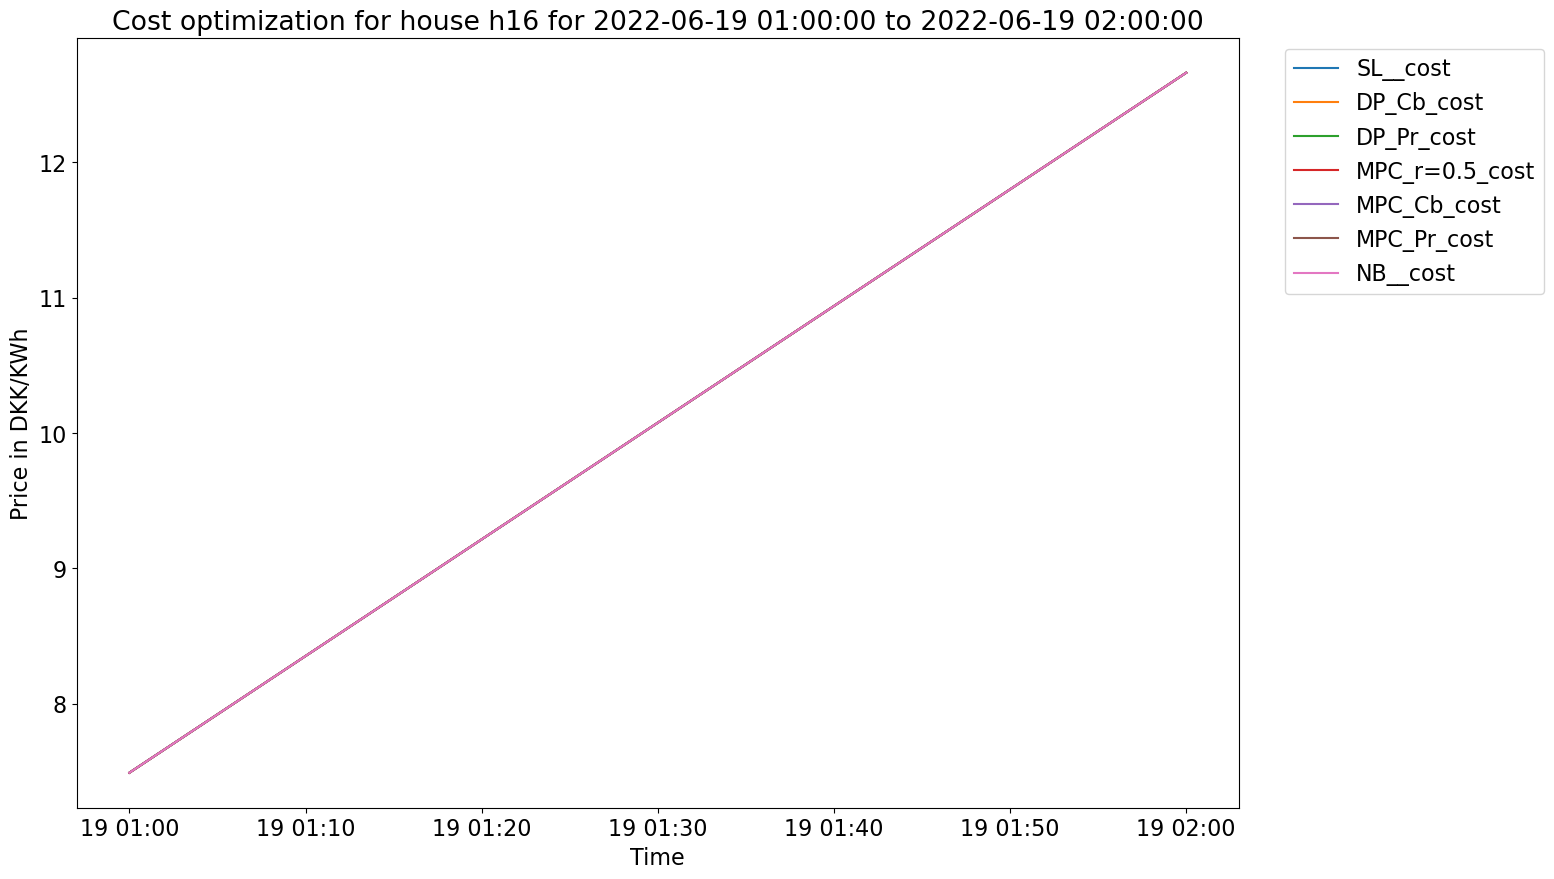

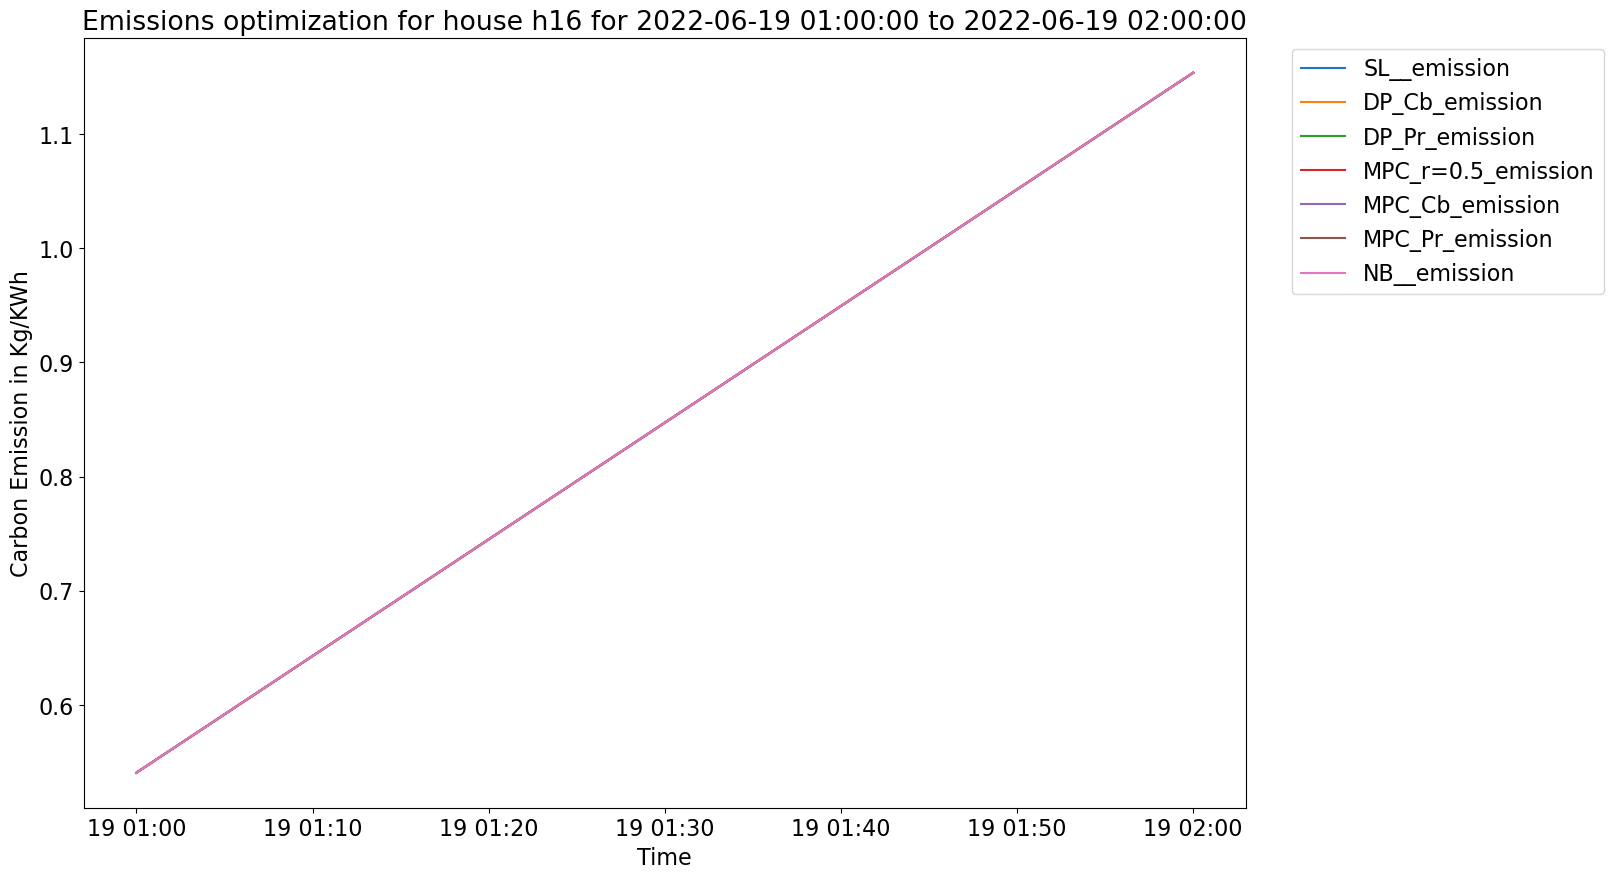

,Cummulated Cost,Cummulated Emissions,Filename,Model,Target Function,col_names
0,12.662533,1.1538,series_battery.csv,SL,,SL_
0,12.662533,1.1538,series_battery_DP_carb.csv,DP,Cb,DP_Cb
0,12.662533,1.1538,series_battery_DP_price.csv,DP,Pr,DP_Pr
0,12.662533,1.1538,series_battery_MPC_both.csv,MPC,r=0.5,MPC_r=0.5
0,12.662533,1.1538,series_battery_MPC_carb.csv,MPC,Cb,MPC_Cb
0,12.662533,1.1538,series_battery_MPC_price.csv,MPC,Pr,MPC_Pr
0,12.662533,1.1538,series_no_battery.csv,NB,,NB_


In [18]:
sho = single_house_opt('h16',start_date='2022-06-19 01:00:00', end_date='2022-06-19 02:00:00') 
sho.get_results('t0','sarima')